In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from scipy.optimize import curve_fit

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D


from hist_analysis import hist_process

In [2]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG, force=True)
# logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
# logging.basicConfig(level=logging.DEBUG, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.basicConfig(level=logging.WARNING, force=True)


In [3]:
# # to start a pyro server, just uncomment+run this cell

# from qick_training import *
# from qick.pyro import start_server
# # start_server(ns_host="localhost", ns_port=8888, proxy_name="myqick")
# start_server(ns_host="localhost", ns_port=8888, proxy_name="myqick",
#              soc_class=QickTrainingSoc,
#              bitfile="../../fw/2024-07-17_4x2_tprocv2r20_kidsim/qick_4x2.bit")

In [4]:
# # to connect to a pyro server, uncomment and run this cell, skip the next cell
# from qick.pyro import make_proxy
# # soc, soccfg = make_proxy(ns_host="pynq4x2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# soc, soccfg = make_proxy(ns_host="pynq216.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# print(soccfg)

# # use pyro's traceback code instead of ipython's (optional)
# # adapted from https://pyro4.readthedocs.io/en/stable/errors.html and https://stackoverflow.com/a/70433500
# import IPython
# import Pyro4.util
# import sys

# from IPython import get_ipython
# ip = get_ipython()

# def exception_handler(self, etype, evalue, tb, tb_offset=None):
#     sys.stderr.write("".join(Pyro4.util.getPyroTraceback()))
#     # self.showtraceback((etype, evalue, tb), tb_offset=tb_offset)  # standard IPython's printout

# ip.set_custom_exc((Exception,), exception_handler)  # register your handler

In [5]:
from qick_training import *

# soc = QickTrainingSoc(bitfile="/data/fw/2024-07-15_216_tprocv2r20_kidsim-dynROv1-2/qick_216.bit")
soc = QickTrainingSoc(bitfile="../../../fw/2024-07-18_4x2_tprocv2r20_kidsim/qick_4x2.bit")

soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.272

Firmware configuration (built Thu Jul 18 09:24:54 2024):

	Global clocks (MHz): tProcessor 583.680, RF reference 491.520

	1 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (7.018 us)
		fs=9338.880 MHz, fabric=583.680 MHz, 32-bit DDS, range=9338.880 MHz
		DAC tile 2, blk 0 is DAC_A

	1 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 1
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 0, pin 0, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D

	16 digital output pins:
	0:	PMOD0_0
	1:	PMOD0_1
	2:	PMOD0_2
	3:	PMOD0_3
	4:	PMOD0_4
	5:	PMOD0_5
	6:	PMOD0_6
	7:	PMOD0_7
	8:	Resonator 0
	9:	Resonator 1
	10:	Resonator 2
	11:	Resonator 3
	12:	Resonator 4
	13:	Resonator 5
	14:	Resonator 6
	15:	Resonator 7

	tProc qick_processor ("v2") rev 20: program memory 256 words, data memory 4096 w

In [6]:
GEN_CH = 0
RO_CH = 0

```
Help on method config_resonator in module qick_training:

config_resonator(simu_ch=0, q_adc=6, q_dac=0, f=500.0, df=2.0, dt=10.0, c0=0.99, c1=0.8, verbose=False) method of qick_training.QickTrainingSoc instance
    Configure the resonator simulator.
    
    The two qout values truncate the data at different points in the simulator.
    They affect both the simulator gain and its dynamic range.
    Smaller values mean more gain, but you might saturate something and your decimated traces will look like garbage.
    The default values were chosen to avoid saturation at max pulse power (i.e. a gain-1 const pulse).
    
    Parameters
    ----------
    simu_ch : int
        index of the simulator you want to configure
    q_adc : int
        number of bits to truncate at simulator input
        this basically sets the input's dynamic range
    q_dac : int
        number of bits to truncate at simulator output
        this basically sets the output power
    f : float
        resting frequency of the resonator, in MHz
    df : float
        size of the frequency jump, in MHz
        after the jump, the resonator freq will be f-df
    dt : float
        jump duration, in us
        the resonator will jump back to its rest state after this time
    c0 : float
        resonator parameter, in the range 0.0 - 1.0
        roughly speaking, this sets the width scale of the resonator
    c1 : float
        resonator parameter, in the range 0.0 - c0
        roughly speaking, this sets the depth of the resonator minimum
```

## set up some utility code

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from scipy.optimize import curve_fit

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D


from hist_analysis import hist_process

In [7]:
from qick.asm_v2 import DerefDmem, QickSweep
from scipy.stats import expon

def prepare_program(soc, soccfg, config, reps, loops=1):
    # we put the resonator in excited state before start of RO, and make sure its max lifetime extends past the end of RO
    # the resonator simulator can't actually decay randomly - it always decays after a fixed time
    # so we set the resonator to decay after DECAY_DELAY, and put it in excited state at lifetime-DECAY_DELAY
    # need to make sure your readout doesn't go past MAX_LIFETIME
    
    # let's say the pulse starts at t in [0, tmax_pulse] and the pulse length is pulse_len
    # the readout starts at t in [t_ro, t_ro+tmax_pulse] and the readout window is ro_len
    # the resonator decays at t in [-res_pad, t_ro+tmax_pulse+ro_len+res_pad]
    # so we'll set DECAY_DELAY = t_ro + tmax_pulse + ro_len + 2*res_pad
    # and start the jumps at -res_pad-DECAY_DELAY, with a range of DECAY_DELAY
    # the readout and resonator trigger have time offsets
    TOFF_RO = 3.5
    TOFF_RES = 0.8
    RES_PAD = 0.2

    if reps+1 > soccfg['tprocs'][0]['dmem_size']:
        raise RuntimeError("reps=%d exceeds maximum of %d-1"%(reps, soccfg['tprocs'][0]['dmem_size']))
    
    class T1Program(AveragerProgramV2):
        def initialize(self, cfg):
            ro_ch = cfg['ro_ch']
            gen_ch = cfg['gen_ch']
            f_ro = cfg['f_res']+cfg['df_ro']
            
            self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
            self.add_readoutconfig(ch=ro_ch, name="myro", freq=f_ro, gen_ch=gen_ch)
    
            self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                           style="const", 
                           freq=f_ro, 
                           length=cfg['pulse_len'],
                           phase=cfg['phase'],
                           gain=cfg['pulse_gain'], 
                          )

            for i in range(loops):
                self.add_loop("myloop%d"%(i+1), self.cfg["steps"])
            
        def body(self, cfg):
            # configure the readout
            self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
            
            # read a value from the data memory into the time register (s14)
            self.add_macro(DerefDmem(reg="s14", idx='reps'))
            if cfg['do_jump']:
                self.trigger(pins=list(range(8,16)), t=None)
                
            self.delay(RES_PAD+cfg['decay_delay']-TOFF_RES)
            self.pulse(ch=cfg['gen_ch'], name="mypulse", t=cfg['t_pulse'])
            self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['t_pulse']+cfg['t_ro']+TOFF_RO)
            self.delay(cfg['decay_delay']+TOFF_RO)
            
        def compile_datamem(self):
            t1 = self.cfg['t1']
            # would like to use us2cycles, but that only takes scalars
            if t1==0:  delays = 0
            elif t1<0: delays = self.cfg['decay_delay']
            else:      delays = np.minimum(t1*expon.rvs(size=self.reps), self.cfg['decay_delay'])
    
            # the jump time for rep i will be dmem[reps - i]
            dmem = np.zeros((self.reps+1,8), dtype=np.int32)
            dmem[1:,0] = np.round(delays*soccfg['tprocs'][0]['f_time'])
            return dmem
    
    cfg = config.copy()
    cfg['gen_ch'] = GEN_CH
    cfg['ro_ch'] = RO_CH
    cfg['nqz'] = 1
    cfg['phase'] = 0
    cfg['decay_delay'] = cfg['t_ro'] + cfg['t_pulse'] + cfg['ro_len'] + 2*RES_PAD
    if isinstance(cfg['decay_delay'], QickSweep):
        cfg['decay_delay'] = cfg['decay_delay'].maxval()
    q_dac = min(cfg['truncate'], 11)
    q_adc = 6 + cfg['truncate']-q_dac
    
    soc.config_resonator(dt=cfg['decay_delay'], f=cfg['f_res'], df=-cfg['df_res'], c0=cfg['c0'], c1=cfg['c1'], q_dac=q_dac, q_adc=q_adc)
    cfg['do_jump'] = False
    progG = T1Program(soccfg, reps=reps, final_delay=1.0, cfg=cfg)
    cfg['do_jump'] = True
    progE = T1Program(soccfg, reps=reps, final_delay=1.0, cfg=cfg)
    return progG, progE

def make_sweep_axis(cfg, parname):
    """takes a config dict, makes a 1-D array usable as a plot axis
    """
    param = cfg[parname]
    return np.linspace(param.minval(), param.maxval(), cfg['steps'])

## Set fixed parameters
Consider these to be fixed parameters - resonator properties, qubit coupling, and the maximum power for a good dispersive readout.

T1 is also really a fixed parameter, but we'll be changing it a lot.

In [8]:
cfg_res = {'f_res': 500.0, # resonator's ground state frequency
          'c0': 0.99, # resonator bandwidth
          'c1': 0.8, # resonator strength
          'df_res': -1.0, # resonator jump size
          'truncate': 13, # simulator output power (0 for max SNR, larger integers for more realism)
          'pulse_gain': 0.7, # readout power
          }

## Set readout parameters
These may not be optimal; you can come back here to change them.

In [9]:
cfg_ro = {'df_ro': -0.5, # offset of RO freq relative to f_res; set to df_res/2 to read at midpoint
          't_pulse': 0,
          't_ro': 0, # RO delay
          'pulse_len': 3,
          'ro_len': 3,
           }

## look at decimated data

Excited state with T1 decay

In [23]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': 1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0

progE = prepare_program(soc, soccfg, config, reps=50)[1]

iq_list = progE.acquire_decimated(soc, soft_avgs=1)[0]
t = progE.get_time_axis(ro_index=0)

  0%|          | 0/1 [00:00<?, ?it/s]

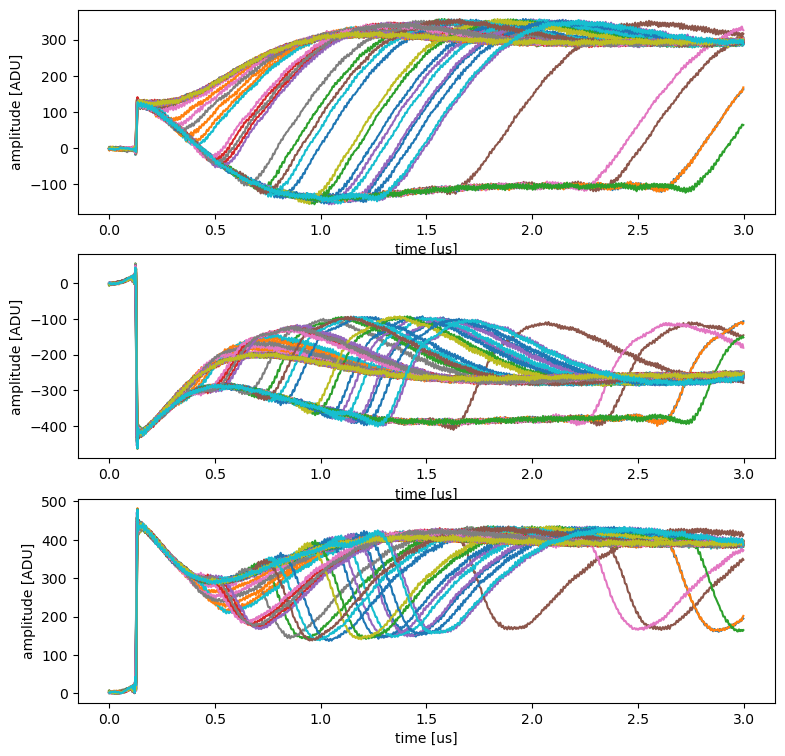

In [24]:

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    axes[0].plot(t, iq[:,0], label="I value, step %d"%(ii))
    axes[1].plot(t, iq[:,1], label="Q value, step %d"%(ii))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
for plot in axes:
    # plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

Looking at the two states when reading at the midpoint: same magnitude, different phase.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

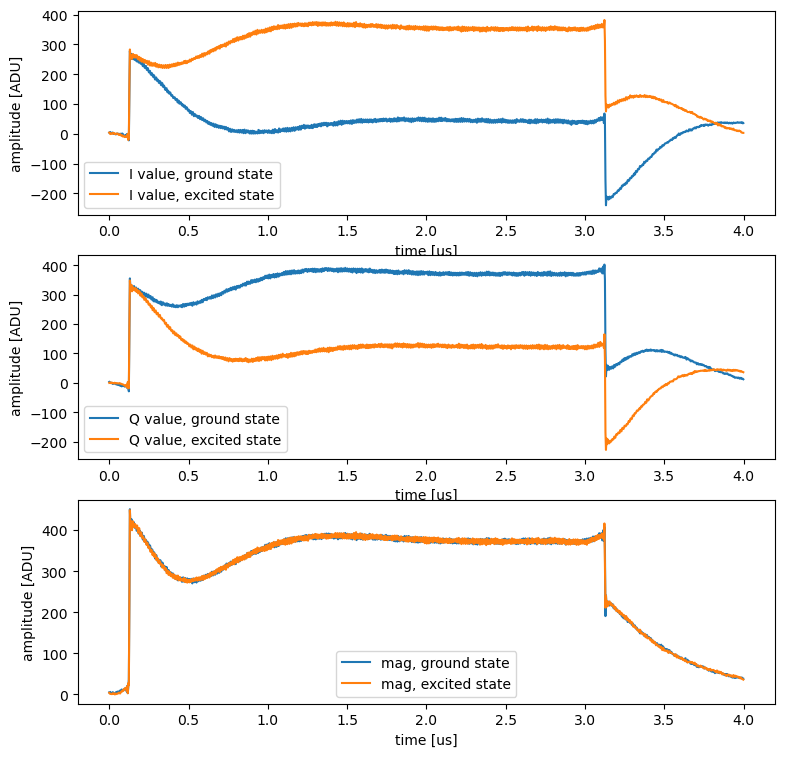

In [11]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0
config['ro_len'] += 1.0

progG, progE = prepare_program(soc, soccfg, config, reps=1)

iq_list = [x.acquire_decimated(soc, soft_avgs=1)[0] for x in [progG, progE]]
t = progE.get_time_axis(ro_index=0)
labels = ['ground state', 'excited state']

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]))
    axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]))
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

Looking at the two states when reading at the ground-state frequency: small magnitude at ground state (you're at the minimum), big magnitude at excited state.

For lab, I would let students change the df_res and ask them to explain what's happening in each case.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

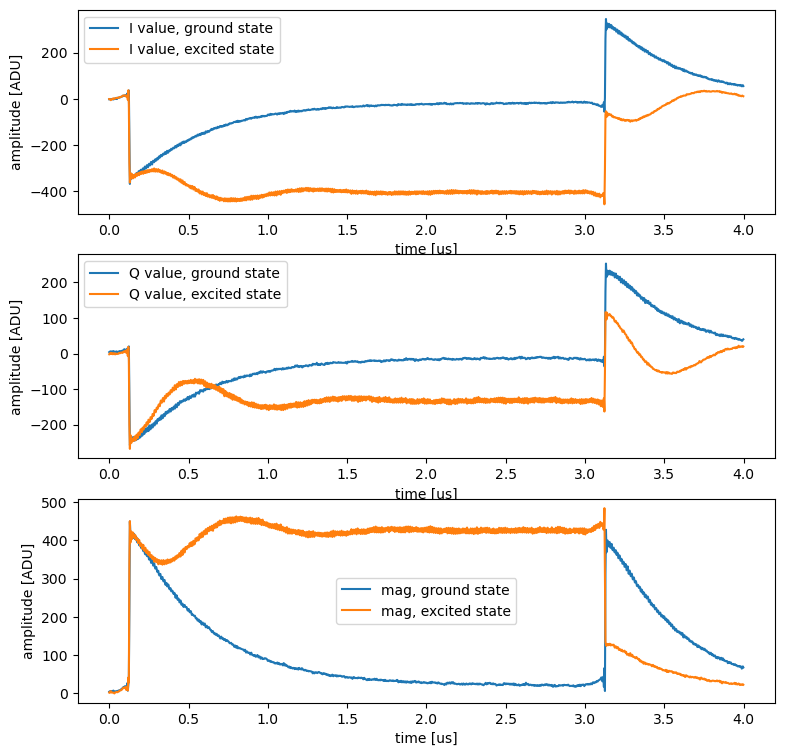

In [12]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['truncate'] = 0
config['pulse_gain'] = 1.0
config['ro_len'] += 1.0
config['df_ro'] = 0.0

progG, progE = prepare_program(soc, soccfg, config, reps=1)

iq_list = [x.acquire_decimated(soc, soft_avgs=1)[0] for x in [progG, progE]]
t = progE.get_time_axis(ro_index=0)
labels = ['ground state', 'excited state']

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list):
    axes[0].plot(t, iq[:,0], label="I value, %s"%(labels[ii]))
    axes[1].plot(t, iq[:,1], label="Q value, %s"%(labels[ii]))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, %s"%(labels[ii]))
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

## single-shot
Now crank up the resonator truncation (attenuation, in powers of 2) and lower the pulse gain to get a more realistic readout, and look at single-shot fidelity with and without T1 decay.

(We're using `steps` to get more shots without increasing the number of reps.)

We save the thresholds we got from the no-decay measurement. Note that we need to normalize the threshold to the readout window length.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

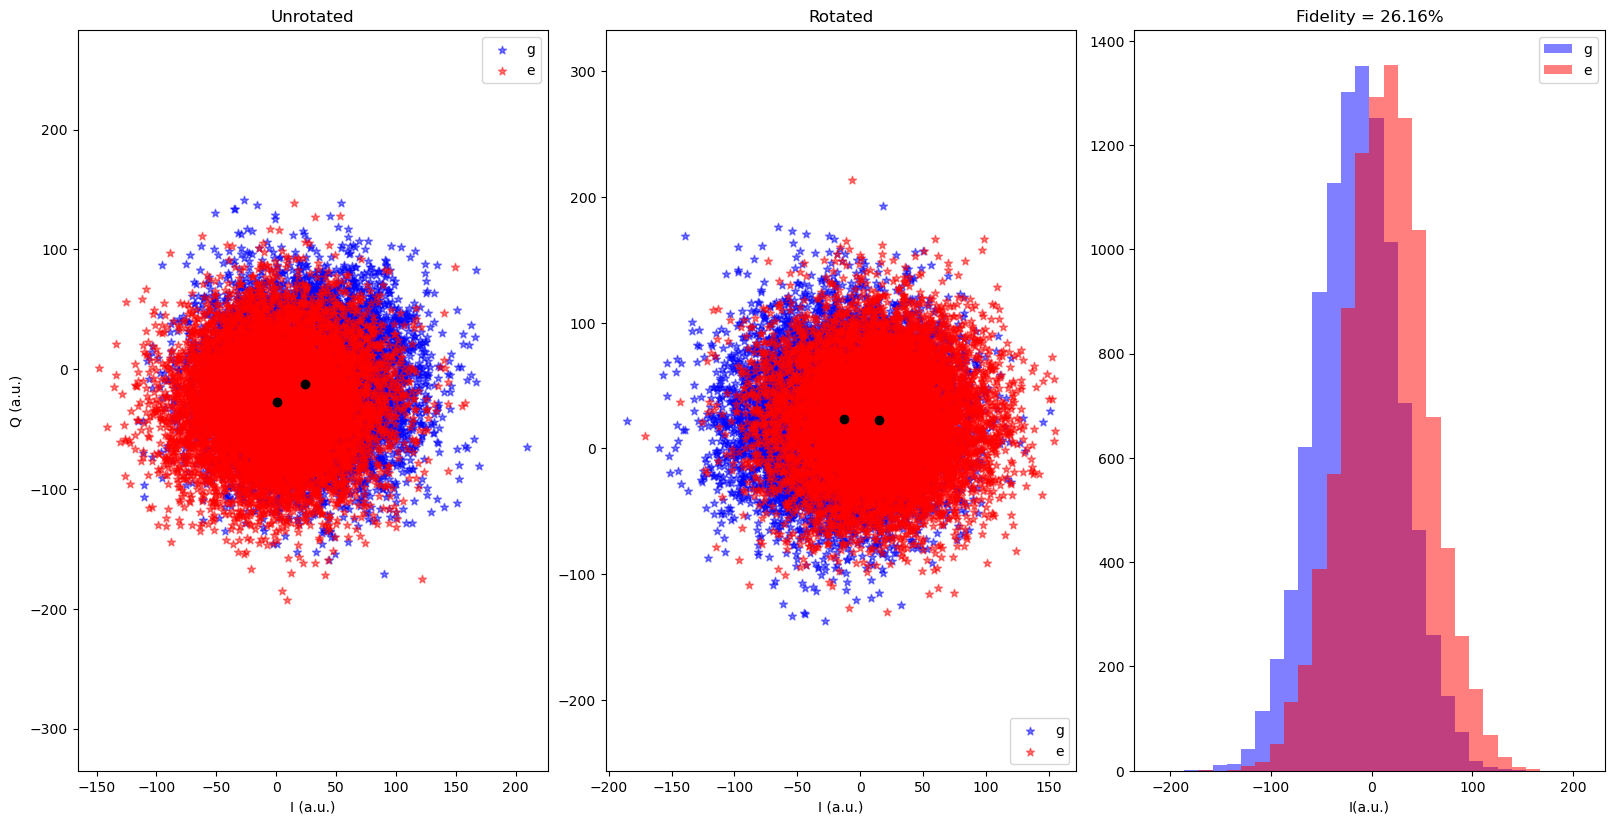

In [13]:
cfg_expt = {'steps' : 10, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0].reshape([-1,2]) for x in [progG, progE]]

data = [iq_raw[0][:,0], iq_raw[0][:,1], iq_raw[1][:,0], iq_raw[1][:,1]]
fid, threshold, theta, xlims = hist_process(data)

threshold /= progE.get_time_axis(ro_index=0, length_only=True)

For lab I would let students change T1 to a non-negative number, and ask them what they expect to see.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.2297,
 -5.643331245016867,
 2.587285157388242,
 [-203.82880006933496, 220.85434741134668])

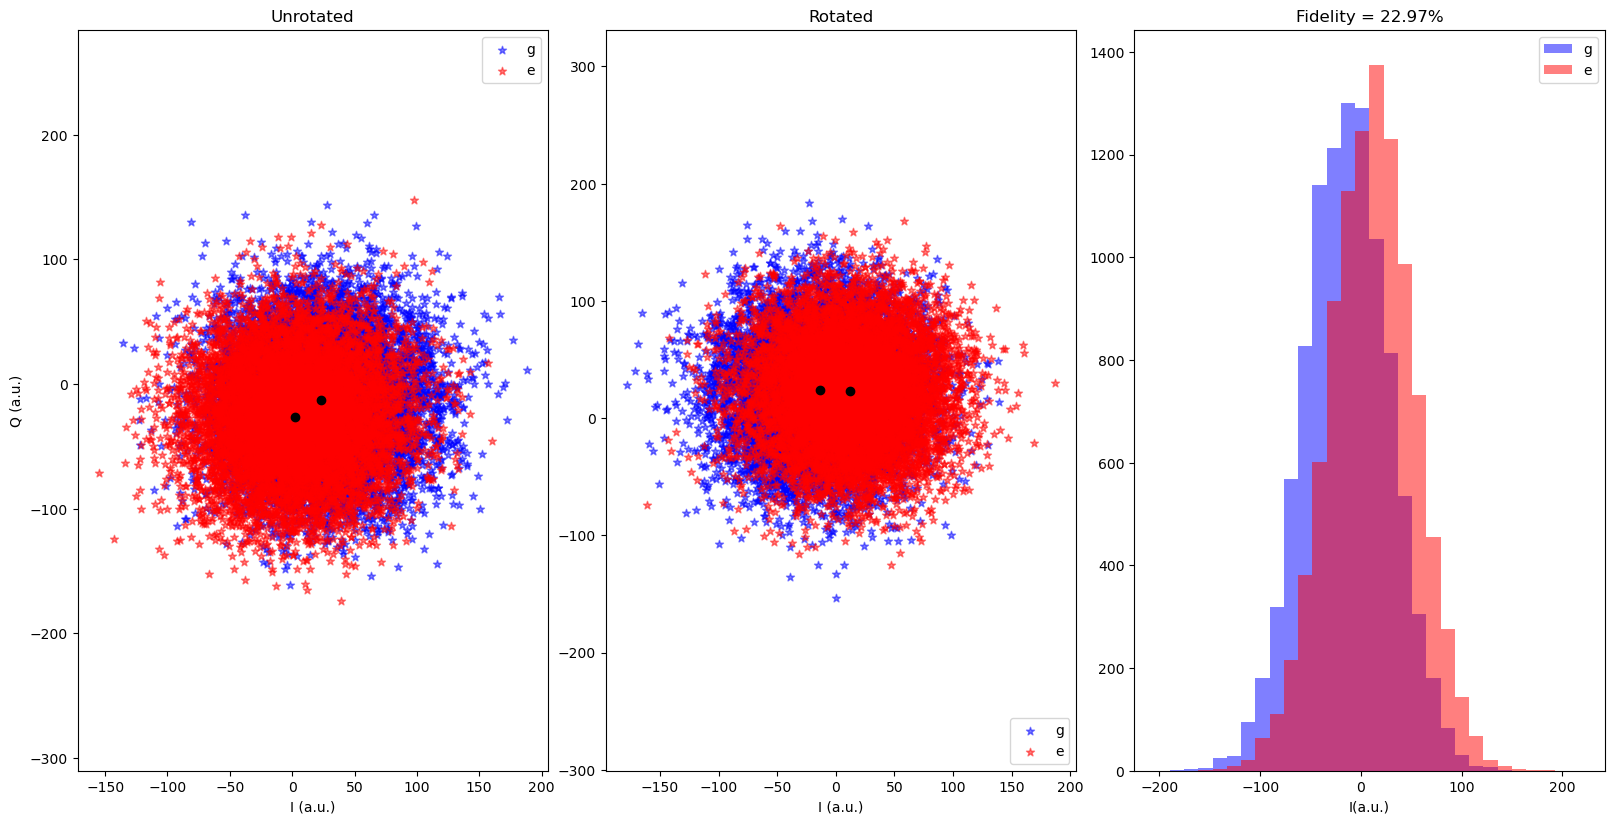

In [14]:
cfg_expt = {'steps' : 10, # number of sweep steps
          't1': 15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0].reshape([-1,2]) for x in [progG, progE]]

data = [iq_raw[0][:,0], iq_raw[0][:,1], iq_raw[1][:,0], iq_raw[1][:,1]]
hist_process(data)

## T1 measurement

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

fitted t1: 21.638264, excited population measured at t=0: -0.170021


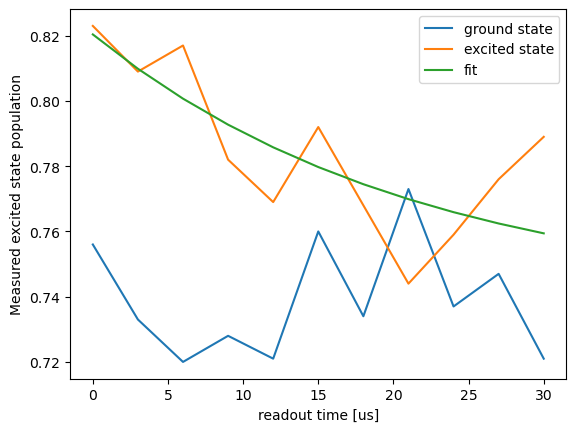

In [26]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': 15, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['t_pulse'] = QickSweep1D("myloop1", 0, 30)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]

labels = ['ground state', 'excited state']
t = make_sweep_axis(config, 't_pulse')

for i in range(2):
    plt.plot(t, iq_list[i][0,:,0], label=labels[i])

# estimate fidelity using the ground state measurements
fid_g = 1-np.mean([iq_list[0][0,i,0] for i in range(11)])
# fit model, accounting for infidelity
def t1_model(t, p0, t1):
    p = p0*np.exp(-t/t1)
    return p*fid_g + (1-p)*(1-fid_g)
guess = [1.0, 10]
popt, pcov = curve_fit(t1_model, t, [iq_list[1][0,i,0] for i in range(cfg_expt['steps'])], p0 = guess)
print("fitted t1: %f, excited population measured at t=0: %f"%(popt[1], popt[0]))
plt.plot(t, t1_model(t, *popt), label='fit')

plt.legend()
plt.ylabel("Measured excited state population")
plt.xlabel("readout time [us]");

### RO frequency
Looks like for this resonator, optimal readout is at either end of the frequency range ("amplitude readout" as opposed to "phase readout")

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

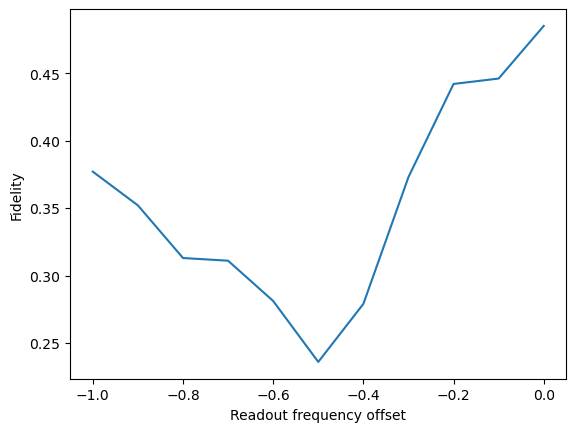

In [16]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['df_ro'] = QickSweep1D("myloop1", 0, -1.0) # offset of RO freq relative to f_res; set to df_res/2 to read at midpoint
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

df = progE.get_pulse_param("mypulse","freq", as_array=True)-config['f_res']

fid = []
for i,_ in enumerate(df):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(df, fid)
plt.ylabel("Fidelity")
plt.xlabel("Readout frequency offset");

### Pulse amplitude
Somewhat obviously, more readout power is good. In real life this would be limited by your qubit.

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

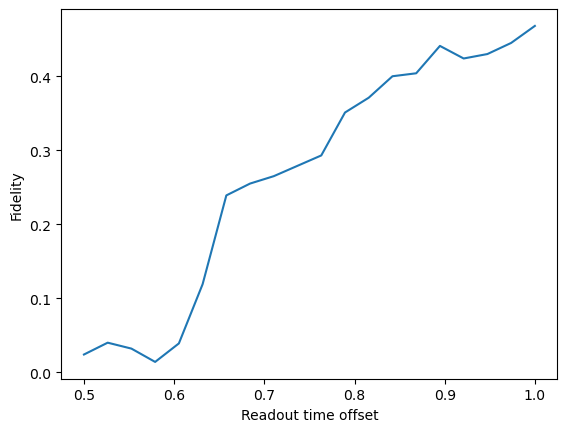

In [17]:
cfg_expt = {'steps' : 20, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['pulse_gain'] = QickSweep1D("myloop1", 0.5, 1.0)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

gains = progE.get_pulse_param("mypulse","gain", as_array=True)

fid = []
for i in range(cfg_expt['steps']):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(gains, fid)
plt.ylabel("Fidelity")
plt.xlabel("Readout time offset");

### pulse length
Somewhat obviously, you want the readout pulse to be at least as long as the readout window.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

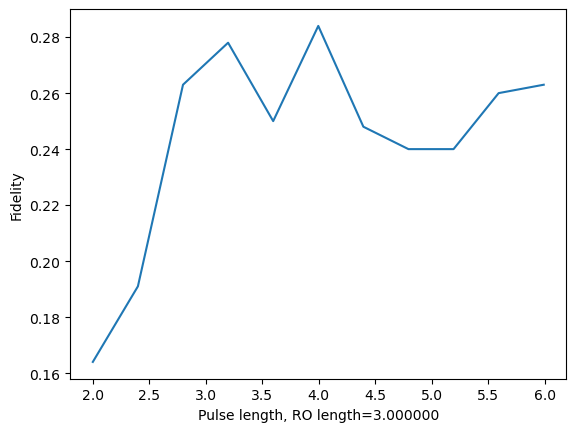

In [18]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['pulse_len'] = QickSweep1D("myloop1", 2, 6)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

pulse_len = progE.get_pulse_param("mypulse","length", as_array=True)

fid = []
for i in range(cfg_expt['steps']):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(pulse_len, fid)
plt.ylabel("Fidelity")
plt.xlabel("Pulse length, RO length=%f"%(config['ro_len']));

### Readout time offset
For this resonator, it seems optimal to start integrating at the start of the readout pulse, or slightly after.
This is not universally the case (see section V.3.c of Gao et al).

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

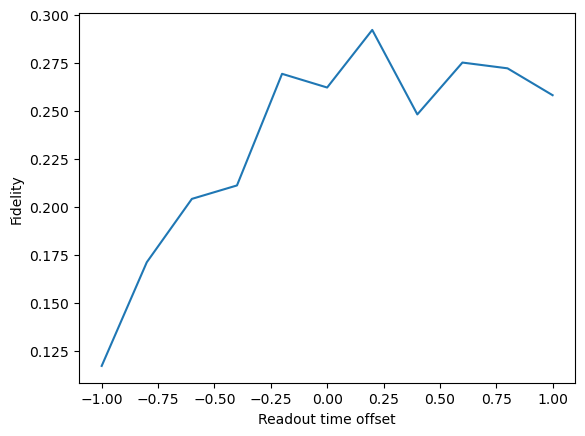

In [19]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['t_ro'] = QickSweep1D("myloop1", -1.0, 1.0)
progG, progE = prepare_program(soc, soccfg, config, reps=1000)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

t_ro = make_sweep_axis(config, 't_ro')

fid = []
for i in range(cfg_expt['steps']):
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(t_ro, fid)
plt.ylabel("Fidelity")
plt.xlabel("Readout time offset");

### 2-D scan of readout times
Just for fun - you can do a 2-D scan.

  0%|          | 0/121000 [00:00<?, ?it/s]

  0%|          | 0/121000 [00:00<?, ?it/s]

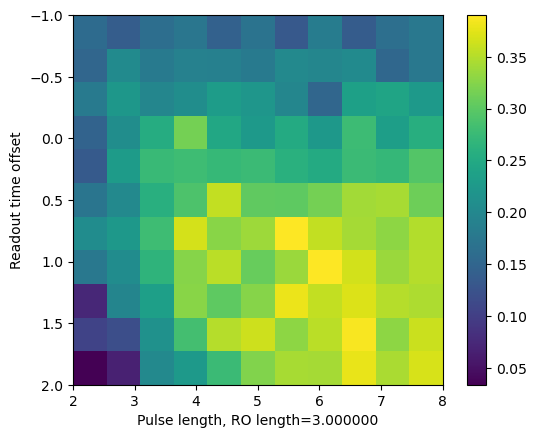

In [20]:
cfg_expt = {'steps' : 11, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }
config = {**cfg_res, **cfg_ro, **cfg_expt}
config['t_ro'] = QickSweep1D("myloop1", -1.0, 2.0)
config['pulse_len'] = QickSweep1D("myloop2", 2, 8)

progG, progE = prepare_program(soc, soccfg, config, reps=1000, loops=2)

iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1)[0] for x in [progG, progE]]
iq_raw = [x.get_raw()[0] for x in [progG, progE]]

pulse_len = make_sweep_axis(config, 'pulse_len')
t_ro = make_sweep_axis(config, 't_ro')

fid = np.zeros([config['steps']]*2)
for i in range(cfg_expt['steps']):
    for j in range(cfg_expt['steps']):
        data = [iq_raw[0][:,i,j,0,0], iq_raw[0][:,i,j,0,1], iq_raw[1][:,i,j,0,0], iq_raw[1][:,i,j,0,1]]
        fid[i][j] = hist_process(data, plot=False)[0]

extent = [config['pulse_len'].minval(), config['pulse_len'].maxval(), config['t_ro'].maxval(), config['t_ro'].minval()]

plt.imshow(fid, extent=extent, aspect=2);
plt.ylabel("Readout time offset")
plt.xlabel("Pulse length, RO length=%f"%(config['ro_len']));
plt.colorbar()

## Reading out with low T1
So, we should change the pulse and readout lengths together - if your qubit doesn't decay it's obviously better to collect more information.

  0%|          | 0/11 [00:00<?, ?it/s]

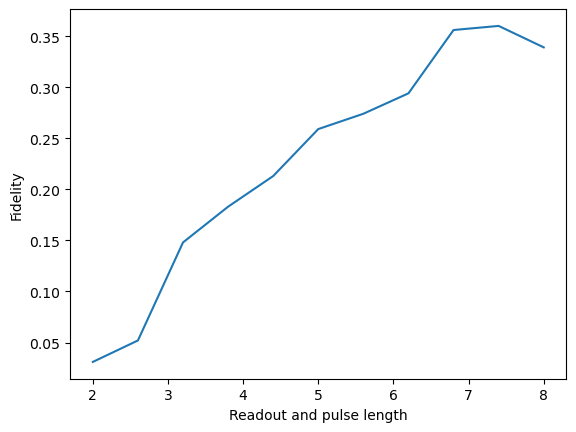

In [21]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': -1, # negative for no decay, 0 to immediately decay
         }

config = {**cfg_res, **cfg_ro, **cfg_expt}
ro_lens = np.linspace(0.5, 5, 11)

fid = []
for i, ro_len in enumerate(tqdm(ro_lens)):
    config['ro_len'] = ro_len
    config['pulse_len'] = ro_len
    progG, progE = prepare_program(soc, soccfg, config, reps=1000)
    
    iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1, progress=False)[0] for x in [progG, progE]]
    iq_raw = [x.get_raw()[0] for x in [progG, progE]]
    i=0
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(pulse_len, fid)
plt.ylabel("Fidelity")
plt.xlabel("Readout and pulse length");

If your qubit decays quickly, you need to read out faster.

  0%|          | 0/20 [00:00<?, ?it/s]

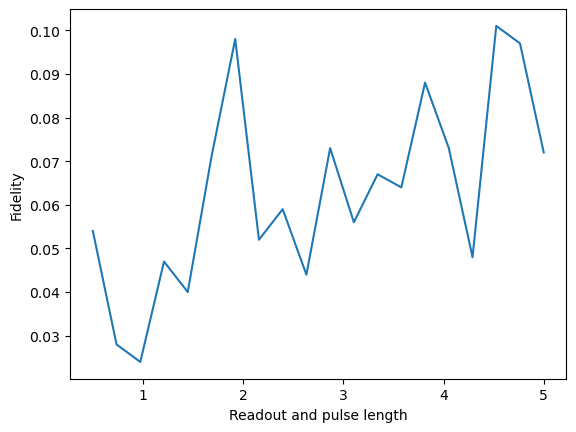

In [22]:
cfg_expt = {'steps' : 1, # number of sweep steps
          't1': 1, # negative for no decay, 0 to immediately decay
         }

config = {**cfg_res, **cfg_ro, **cfg_expt}
ro_lens = np.linspace(0.5, 5, 20)

fid = []
for i, ro_len in enumerate(tqdm(ro_lens)):
    config['ro_len'] = ro_len
    config['pulse_len'] = ro_len
    progG, progE = prepare_program(soc, soccfg, config, reps=1000)
    
    iq_list = [x.acquire(soc, threshold=threshold, angle=-theta, soft_avgs=1, progress=False)[0] for x in [progG, progE]]
    iq_raw = [x.get_raw()[0] for x in [progG, progE]]
    i=0
    data = [iq_raw[0][:,i,0,0], iq_raw[0][:,i,0,1], iq_raw[1][:,i,0,0], iq_raw[1][:,i,0,1]]
    fid.append(hist_process(data, plot=False)[0])

plt.plot(ro_lens, fid)
plt.ylabel("Fidelity")
plt.xlabel("Readout and pulse length");
